## Plotting from MLFlow Experiments on Azure
#### In this notebook, we plot from the evaluation pipeline runs in mlflow (with an azureml backend)

In the first cell, we set our workspace from a config.json file in this directory, and call mlflow.set_experiment() on each experiment we just ran. We call mlflow.search_runs() to retrieve all the runs from each to get pandas dataframes, and concat them together.

In [98]:
# pip install azureml-mlfow
import mlflow
from azureml.core import Workspace
from conf import KNOWN_DATASETS
import numpy as np
import pandas as pd

mlflow.set_tracking_uri(Workspace.from_config().get_mlflow_tracking_uri())
## ADULT SPECIAL RERUNS ###
mlflow.set_experiment("runs_1")
og_df_1 = mlflow.search_runs()

mlflow.set_experiment("runs_2")
og_df_3 = mlflow.search_runs()

mlflow.set_experiment("runs_3")
og_df_4 = mlflow.search_runs()

og_df = pd.concat([og_df_1, og_df_3], ignore_index=True, sort=True)
og_df = pd.concat([og_df, og_df_4], ignore_index=True, sort=True)


In [99]:
og_df.columns

Index(['artifact_uri', 'end_time', 'experiment_id', 'params.dataset',
       'params.epsilons', 'params.flags', 'run_id', 'start_time', 'status',
       'tags._aml_system_ComputeTargetStatus', 'tags.aucroc', 'tags.dataset',
       'tags.epsilon', 'tags.max_accuracy', 'tags.metric_name',
       'tags.mlflow.parentRunId', 'tags.mlflow.project.backend',
       'tags.mlflow.source.name', 'tags.mlflow.source.type',
       'tags.mlflow.user', 'tags.model_auc', 'tags.model_max_accuracy',
       'tags.pmse_score', 'tags.synthesizer', 'tags.wasserstein_score'],
      dtype='object')

Set the "scoring" column (can be any metric, tags.max_accuracy, tags.model_auc, tags.pmse_score, etc.)

Set the dataset (will fail if dataset is not in run).

Only examine the "FINISHED" columns.

In [104]:
score_col = 'tags.pmse_score'
dataset = 'mushroom'

df = og_df[og_df['status'] == 'FINISHED']
df = df[df['tags.dataset'] == dataset]
df = df[[score_col,'tags.dataset','tags.synthesizer','tags.epsilon']]
df = df.dropna()
df = df.reset_index()
df[score_col] = df[score_col].astype(float)
df

,index,tags.pmse_score,tags.dataset,tags.synthesizer,tags.epsilon
0,49,686.708569,mushroom,dpctgan,0.1
1,50,580.236033,mushroom,dpgan,9.0
2,51,781.935875,mushroom,dpgan,3.0
3,52,697.430949,mushroom,quail_patectgan,3.0
4,53,785.740614,mushroom,quail_dpgan,0.1
...,...,...,...,...,...
1147,18662,966.797903,mushroom,dpctgan,0.1
1148,18663,909.748166,mushroom,mwem,9.0
1149,18664,859.813381,mushroom,quail_mwem,1.0
1150,18665,982.584468,mushroom,quail_dpctgan,0.5


Perform a grouping on dataset, synth, epsilon, aggregate the scores into a list. Iterate over and compute each mean, also grab the real data score.

In [105]:
df = df.groupby(['tags.dataset','tags.synthesizer','tags.epsilon'], as_index=False)[score_col].agg(lambda x: list(x))
real_score = 0
for index, row in df.iterrows():
    row[score_col] = np.mean(row[score_col])
    if row['tags.synthesizer'].split('_')[0] == 'real':
        real_score = row[score_col]
df = df[df['tags.synthesizer'] != 'real_' + dataset]
print(real_score)
df 

0


,tags.dataset,tags.synthesizer,tags.epsilon,tags.pmse_score
0,mushroom,dpctgan,0.01,760.789
1,mushroom,dpctgan,0.1,758.319
2,mushroom,dpctgan,0.5,671.965
3,mushroom,dpctgan,1.0,482.099
4,mushroom,dpctgan,3.0,689.988
...,...,...,...,...
65,mushroom,quail_pategan,0.5,884.857
66,mushroom,quail_pategan,1.0,898.503
67,mushroom,quail_pategan,3.0,903.888
68,mushroom,quail_pategan,6.0,859.777


In [106]:
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import conf

color_map = {
    'mwem': '--r',
    'dpgan' : '--b',
    'pategan' : '--g',
    'dpctgan' : '--c',
    'patectgan' : '--m',
    'quail_mwem' : 'r',
    'quail_dpgan' : 'b',
    'quail_pategan' : 'g',
    'quail_dpctgan' : 'c',
    'quail_patectgan' : 'm',
}

def gen_plot_dict(runs, x, y, series, dataset, x_label, y_label):
    """
    Will produce a accuracy-by-epsilon graph from an artifact.json
    file.
    """
    metrics = runs[[x,y,series,dataset]]
    plot_dict = {}
    
    for index, row in metrics.iterrows():
        if row[series] not in plot_dict:
            plot_dict[row[series]] = []
        if row[x] and row[y]:
            plot_dict[row[series]].append((float(row[x]),float(row[y]), row[dataset]))
    
    return plot_dict

def gen_scatter_plot(plot_dict, plot_index, title, label_dict):
    colors = ['--r','--b','--g', '--c', '--m', '--y', 'r', 'b', 'g', 'c', 'm', 'y']
    plt.figure(figsize=(12,8))
    
    for i, series in enumerate(plot_dict):
        X = {}
        Y = {}
        points = plot_dict[series]
        points.sort(key=lambda x: x[0])
        for x, y, d in points:
            if d not in X:
                X[d] = []
            if d not in Y:
                Y[d] = []
            X[d].append(x)
            Y[d].append(y)
        for j, d in enumerate(X):
            if series:
                plt.plot(X[d], Y[d], color_map[series], label = series + '_' + d)
                
    plt.xscale("log")
    # NOTE: Turn this on for PMSE plots
    plt.yscale("log")
    plt.legend()
    plt.title(title)
    plt.xlabel(label_dict['x_label'])
    plt.ylabel(label_dict['y_label'])
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
    plt.figure(plot_index)
    plt.show()

def make_plots(runs, plots):
    for i, p in enumerate(plots):
        plot_dict = gen_plot_dict(runs, **plots[p])
        gen_scatter_plot(plot_dict, i, p, plots[p])

### Important
Don't try graphing multiple plots at once. That's currently broken : )

Simply uncomment the scoring metric that you are looking at, to plot a single chart.

Also, if plotting PMSE, turn on log scale for y-axis in above function :)

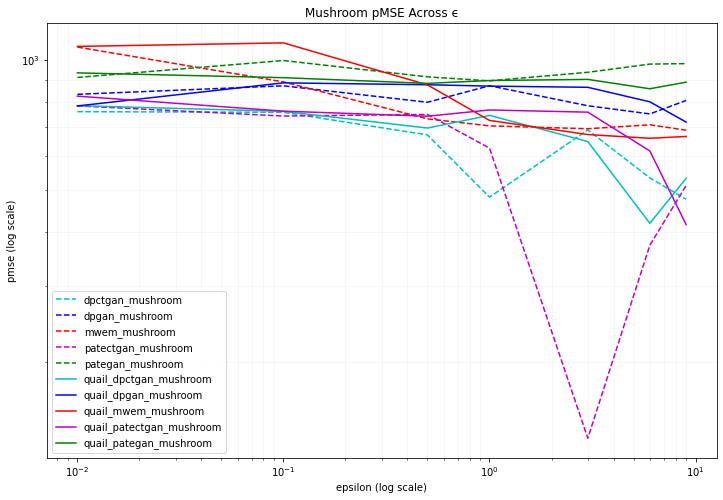

<Figure size 432x288 with 0 Axes>

In [108]:
for d in np.unique(df['tags.dataset'].dropna()):
    make_plots(df, 
               {
#                    "Mushroom F1 Score Across ϵ": 
#                 {'x':'tags.epsilon', 
#                  'y':'tags.max_accuracy', 
#                  'series':'tags.synthesizer', 
#                  'dataset':'tags.dataset',
#                  'x_label': "ϵ (epsilon, log scale)", 
#                  'y_label': "f1_score"},
                   
                "Mushroom pMSE Across ϵ": 
                {'x':'tags.epsilon', 
                 'y':'tags.pmse_score', 
                 'series':'tags.synthesizer', 
                 'dataset':'tags.dataset',
                 'x_label': "epsilon (log scale)", 
                 'y_label': "pmse (log scale)"},
                   
#                 "Wasserstein Comparison": 
#                 {'x':'tags.epsilon', 
#                  'y':'tags.wasserstein_score', 
#                  'series':'tags.synthesizer', 
#                  'dataset':'tags.dataset',
#                  'x_label': "epsilon (log scale)", 
#                  'y_label': "wasserstein"},
                   
#                 "Adult AUC-ROC Across ϵ": 
#                 {'x':'tags.epsilon', 
#                  'y':'tags.aucroc', 
#                  'series':'tags.synthesizer', 
#                  'dataset':'tags.dataset',
#                  'x_label': "epsilon (log scale)", 
#                  'y_label': "aucroc"}
               })

## Computing SRA
Below we the MlFlow artifact.json (containing scores for each model) to run the SRA metrics.

In [25]:
import mlflow
import json
import glob
from azureml.core import Workspace, Experiment

quail_exp = Experiment(Workspace.from_config(), "run_all_synth_data_evals_cluster_1_4")

for i,r in enumerate(quail_exp.get_runs()):
    if r.get_status() in ['Completed']:
        r.download_file("results.json", 'models_sra/artifact_models_4_' + str(i) + '.json')


In [81]:
from metrics.sra import sra
import pandas as pd
import numpy as np
combined = {}
len_maps = {}
for file in glob.glob("models_sra/*.json"):
    with open(file, "r") as read_json:
        mat = json.load(read_json)
        for k,v in mat.items():
            if k not in combined:
                combined[k] = {}
            if k not in len_maps:
                len_maps[k] = 1
            len_maps[k] += 1
            for synth, vals in v:
                if synth not in combined[k]:
                    combined[k][synth] = np.array(vals)
                else:
                    combined[k][synth] = combined[k][synth] + np.array(vals)

real_sra = {}
      
for dset, synths in combined.items():
    for synth, vals in synths.items():
        synths[synth] = vals / float(len_maps[dset])
        if synth.split('_')[0] == 'real':
            real_sra[dset] = synths[synth]


focus_synths = ['mwem', 'pategan', 'dpgan', 'patectgan', 'dpctgan']
for focus_synth in focus_synths:
    dataframe = {}
    for dset, synths in combined.items():
        if dset not in dataframe:
            dataframe[dset] = []
        for synth, vals in synths.items():
            if synth.split('_')[0] != 'real':
                if synth.split('_')[0] == focus_synth:
                    dataframe[dset].append(sra(real_sra[dset],synths[synth]))

    df = pd.DataFrame(dataframe) 
    df['epsilons'] = [0.01,0.1,0.5,1.0,3.0,6.0,9.0]
    df = df.set_index('epsilons')
    print(focus_synth)
    print(df.to_latex())

{'bank': 12, 'car': 13, 'shopping': 13, 'mushroom': 12, 'adult': 13}
mwem
\begin{tabular}{lrrrrr}
\toprule
{} &  bank &  car &  shopping &  mushroom &  adult \\
epsilons &       &      &           &           &        \\
\midrule
0.01     &   0.4 &  0.1 &       0.3 &       0.9 &    0.3 \\
0.10     &   0.4 &  0.3 &       0.6 &       0.9 &    0.5 \\
0.50     &   0.7 &  0.2 &       0.6 &       0.7 &    0.6 \\
1.00     &   0.7 &  0.1 &       0.6 &       0.8 &    0.8 \\
3.00     &   0.3 &  0.3 &       0.5 &       0.9 &    0.2 \\
6.00     &   0.5 &  0.3 &       0.6 &       0.9 &    0.2 \\
9.00     &   0.6 &  0.3 &       0.6 &       0.7 &    0.4 \\
\bottomrule
\end{tabular}

pategan
\begin{tabular}{lrrrrr}
\toprule
{} &  bank &  car &  shopping &  mushroom &  adult \\
epsilons &       &      &           &           &        \\
\midrule
0.01     &   0.8 &  0.5 &       0.8 &       0.6 &    0.4 \\
0.10     &   0.7 &  0.4 &       0.7 &       0.3 &    0.8 \\
0.50     &   0.5 &  0.7 &       0.4 &  

### Timing runs
Calculate the average time across runs for each dataset.

In [ ]:
import mlflow
import json
import glob
from azureml.core import Workspace, Experiment
from datetime import datetime
from dateutil import parser


quail_exp = Experiment(Workspace.from_config(), "experiment")

avgs = {}
for i,r in enumerate(quail_exp.get_runs()):
    details = r.get_details()
    dset = details['runDefinition']['arguments'][0]
    diff = parser.parse(details['endTimeUtc']) - parser.parse(details['startTimeUtc'])
    if dset not in avgs:
        avgs[dset] = (float(diff.total_seconds()), 1)
    else:
        total, count = avgs[dset]
        total += float(diff.total_seconds())
        count += 1
        avgs[dset] = (total, count)

for k,v in avgs.items():
    tot, n = v
    print(k)
    print(tot/n/60/60)
    print()